In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

In [7]:
# ============================
# CONFIGURATION
# ============================
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
NUM_CLASSES = 3


PUBLIC_PREP_DIR = "../preprocessed_Public"
SELF_PREP_DIR = "../preprocessed_self"

In [8]:
# ============================
# DATA GENERATORS
# ============================


# Training & validation generator (public dataset)
train_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input
)


val_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input
)


train_gen = train_datagen.flow_from_directory(
os.path.join(PUBLIC_PREP_DIR, "train"),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical'
)


val_gen = val_datagen.flow_from_directory(
os.path.join(PUBLIC_PREP_DIR, "val"),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical'
)


# Test generator (self-collected dataset)
test_gen = val_datagen.flow_from_directory(
os.path.join(SELF_PREP_DIR, "test"),
target_size=(IMG_SIZE, IMG_SIZE),
batch_size=BATCH_SIZE,
class_mode='categorical',
shuffle=False
)


print("✅ Data generators ready")

Found 7512 images belonging to 3 classes.
Found 403 images belonging to 3 classes.
Found 512 images belonging to 3 classes.
✅ Data generators ready


In [9]:
# ============================
# MODEL ARCHITECTURE
# ============================


# Load MobileNetV3-Large backbone
base_model = MobileNetV3Large(
input_shape=(IMG_SIZE, IMG_SIZE, 3),
include_top=False,
weights='imagenet'
)


# Freeze backbone for transfer learning
base_model.trainable = False


# Custom classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)


model = Model(inputs=base_model.input, outputs=outputs)


print("✅ MobileNetV3-Large model built")
model.summary()

I0000 00:00:1769947346.283598   10454 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5561 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


✅ MobileNetV3-Large model built


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, 112, 112,  │        432 │ rescaling[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, 112, 112,  │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 112, 112,  │          0 │ conv_bn[0][0]     │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        144 │ activation[0][0]  │
│ (DepthwiseConv2D)   │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        256 │ re_lu[0][0]       │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, 112, 112,  │          0 │ activation[0][0], │
│ (Add)               │ 16)               │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, 112, 112,  │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 112, 112,  │          0 │ expanded_conv_1_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 113, 113,  │          0 │ re_lu_1[0][0]     │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, 56, 56,    │        256 │ expanded_conv_1_

 Total params: 3,243,139 (12.37 MB)

 Trainable params: 246,787 (964.01 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [10]:
# ============================
# COMPILE MODEL
# ============================


model.compile(
optimizer=Adam(learning_rate=1e-4),
loss='categorical_crossentropy',
metrics=['accuracy']
)


print("✅ Model compiled")

✅ Model compiled


In [11]:
# ============================
# CALLBACKS
# ============================


early_stop = EarlyStopping(
monitor='val_loss',
patience=5,
restore_best_weights=True,
verbose=1
)


reduce_lr = ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=3,
min_lr=1e-6,
verbose=1
)

In [12]:
# ============================
# TRAINING
# ============================


print("🚀 Starting MobileNetV3-Large training...\n")


history = model.fit(
train_gen,
epochs=EPOCHS,
validation_data=val_gen,
callbacks=[early_stop, reduce_lr],
verbose=1
)


print("✅ Training completed")

🚀 Starting MobileNetV3-Large training...

Epoch 1/30


2026-02-01 20:02:31.226549: I external/local_xla/xla/service/service.cc:163] XLA service 0x70193c010ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-01 20:02:31.226583: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2026-02-01 20:02:31.338879: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-01 20:02:32.201065: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91801
2026-02-01 20:02:32.355352: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-01 20:02:33.236318: I e

197/235 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6221 - loss: 0.9170

2026-02-01 20:02:49.858912: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3335', 4 bytes spill stores, 4 bytes spill loads

2026-02-01 20:02:49.943655: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3284', 8 bytes spill stores, 8 bytes spill loads

2026-02-01 20:02:56.370352: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 20:02:56.521022: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 20:02:56.669175: E external/local_xla/xla/s

235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.6453 - loss: 0.8624

2026-02-01 20:03:08.021852: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1586', 16 bytes spill stores, 16 bytes spill loads

2026-02-01 20:03:08.040011: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1586', 12 bytes spill stores, 12 bytes spill loads

2026-02-01 20:03:08.175396: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1579', 8 bytes spill stores, 8 bytes spill loads

2026-02-01 20:03:12.025901: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 20:03:12.183147: E external/local_xl

235/235 ━━━━━━━━━━━━━━━━━━━━ 49s 144ms/step - accuracy: 0.7757 - loss: 0.5573 - val_accuracy: 0.9280 - val_loss: 0.2435 - learning_rate: 1.0000e-04
Epoch 2/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9155 - loss: 0.2306 - val_accuracy: 0.9380 - val_loss: 0.1968 - learning_rate: 1.0000e-04
Epoch 3/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9466 - loss: 0.1591 - val_accuracy: 0.9380 - val_loss: 0.1776 - learning_rate: 1.0000e-04
Epoch 4/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9595 - loss: 0.1203 - val_accuracy: 0.9504 - val_loss: 0.1672 - learning_rate: 1.0000e-04
Epoch 5/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9675 - loss: 0.0988 - val_accuracy: 0.9429 - val_loss: 0.1544 - learning_rate: 1.0000e-04
Epoch 6/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9731 - loss: 0.0796 - val_accuracy: 0.9479 - val_loss: 0.1515 - learning_rate: 1.0000e-04
Epoch 7/30
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.


📊 Evaluating on SELF-COLLECTED dataset...
Test Accuracy: 66.02%
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step

📋 Classification Report
              precision    recall  f1-score   support

   aluminium       0.64      0.55      0.59       127
       paper       0.56      0.75      0.64       151
     plastic       0.77      0.66      0.71       234

    accuracy                           0.66       512
   macro avg       0.66      0.65      0.65       512
weighted avg       0.68      0.66      0.66       512



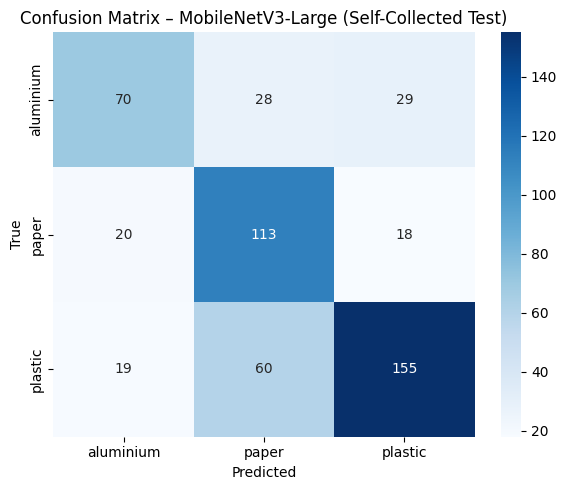

✅ Evaluation completed


In [13]:
# ============================
# EVALUATION ON SELF-COLLECTED DATA
# ============================


print("\n📊 Evaluating on SELF-COLLECTED dataset...")


test_loss, test_acc = model.evaluate(test_gen, verbose=0)
print(f"Test Accuracy: {test_acc*100:.2f}%")


# Predictions
y_pred_prob = model.predict(test_gen)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = test_gen.classes


# Classification report
print("\n📋 Classification Report")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
xticklabels=test_gen.class_indices.keys(),
yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix – MobileNetV3-Large (Self-Collected Test)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


print("✅ Evaluation completed")